# Data Prep

## Download D3 dataset

In [ ]:
from datasets import load_dataset
import pandas as pd
import os
from io import BytesIO
import numpy as np
import requests
from PIL import Image

# Load dataset in streaming mode
dataset = load_dataset("elsaEU/ELSA_D3", split="train", streaming=True)

batch_size = 100  # Adjust based on your memory
train_batch_num = 0
val_batch_num = 0
test_batch_num = 0

# Create output folders
train_folder = "train"
val_folder = "val"
test_folder = "test"
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# SET YOUR LIMIT HERE
MAX_EXAMPLES = 4000  # Download 700 examples total
TRAIN_SPLIT = 0.7   # 70% for training
VAL_SPLIT = 0.15    # 15% for validation
TEST_SPLIT = 0.15   # 15% for testing

TRAIN_SIZE = int(MAX_EXAMPLES * TRAIN_SPLIT)  # 490 for train
VAL_SIZE = int(MAX_EXAMPLES * VAL_SPLIT)       # 105 for val
TEST_SIZE = MAX_EXAMPLES - TRAIN_SIZE - VAL_SIZE  # 105 for test

print(f"Dataset split:")
print(f"  Train: {TRAIN_SIZE} examples")
print(f"  Val:   {VAL_SIZE} examples")
print(f"  Test:  {TEST_SIZE} examples")
print(f"  Total: {MAX_EXAMPLES} examples\n")

def download_image_from_url(url, timeout=10):
    """Download image from URL and return as bytes"""
    try:
        response = requests.get(url, timeout=timeout)
        response.raise_for_status()
        # Convert to PIL Image and back to bytes to ensure it's valid
        img = Image.open(BytesIO(response.content)).convert('RGB')
        buffer = BytesIO()
        img.save(buffer, format='PNG')
        return buffer.getvalue()
    except Exception as e:
        print(f"    Error downloading image from {url}: {e}")
        return None

def convert_and_map_columns(example, index):
    """Convert PIL Images to bytes and map to expected column names"""
    converted = {}
    
    # Map column names to what get_data.py expects
    converted['img_id'] = example.get('id', '')
    converted['original_prompt'] = example.get('original_prompt', '')
    converted['positive_prompt'] = example.get('positive_prompt', '')
    converted['img_url'] = example.get('url', '')
    
    # Create metadata as strings for each generated image
    for i in range(4):
        meta = {
            'model': example.get(f'model_gen{i}', ''),
            'width': example.get(f'width_gen{i}', 0),
            'height': example.get(f'height_gen{i}', 0),
            'num_inference_steps': example.get(f'num_inference_steps_gen{i}', 0),
            'filepath': example.get(f'filepath_gen{i}', '')
        }
        converted[f'image_gen{i}_meta'] = str(meta)
    
    # Download the REAL image from URL
    real_image_url = example.get('url', '')
    if real_image_url:
        print(f"  Example {index}: Downloading real image from URL...")
        real_image_bytes = download_image_from_url(real_image_url)
        if real_image_bytes:
            converted['image'] = real_image_bytes  # Store as 'image' column
        else:
            print(f"  Example {index}: Failed to download real image, skipping this example")
            return None
    else:
        print(f"  Example {index}: No URL for real image, skipping")
        return None
    
    # Convert generated PIL Images to bytes
    for key, value in example.items():
        if hasattr(value, 'save') and hasattr(value, 'mode'):
            buffer = BytesIO()
            value.save(buffer, format='PNG')
            converted[key] = buffer.getvalue()
        elif key not in converted and not key.startswith('model_') and \
             not key.startswith('width_') and not key.startswith('height_') and \
             not key.startswith('num_inference_steps_') and not key.startswith('filepath_'):
            # Keep other non-metadata columns
            converted[key] = value
    
    return converted

train_batch = []
val_batch = []
test_batch = []
total_processed = 0
train_count = 0
val_count = 0
test_count = 0
skipped = 0

for i, example in enumerate(dataset):
    # Stop after reaching the limit
    if total_processed >= MAX_EXAMPLES:
        print(f"\nReached limit of {MAX_EXAMPLES} examples. Stopping download.")
        break
    
    try:
        result = convert_and_map_columns(example, i)
        if result is not None:
            # Assign to train/val/test based on count
            if train_count < TRAIN_SIZE:
                train_batch.append(result)
                train_count += 1
                split_name = "TRAIN"
            elif val_count < VAL_SIZE:
                val_batch.append(result)
                val_count += 1
                split_name = "VAL"
            else:
                test_batch.append(result)
                test_count += 1
                split_name = "TEST"
            
            total_processed += 1
            
            # Show progress every 10 examples
            if total_processed % 10 == 0:
                print(f"Progress: {total_processed}/{MAX_EXAMPLES} (Train: {train_count}/{TRAIN_SIZE}, Val: {val_count}/{VAL_SIZE}, Test: {test_count}/{TEST_SIZE}, Skipped: {skipped})")
        else:
            skipped += 1
            
    except Exception as e:
        print(f"Error processing example {i}: {e}")
        skipped += 1
        continue
    
    # Save train batch when full
    if len(train_batch) >= batch_size:
        df = pd.DataFrame(train_batch)
        df.to_parquet(
            f"{train_folder}/{train_batch_num}.parquet",
            engine='pyarrow',
            compression='gzip'
        )
        print(f"✓ Saved {train_folder}/{train_batch_num}.parquet ({len(train_batch)} rows)")
        train_batch = []
        train_batch_num += 1
    
    # Save val batch when full
    if len(val_batch) >= batch_size:
        df = pd.DataFrame(val_batch)
        df.to_parquet(
            f"{val_folder}/{val_batch_num}.parquet",
            engine='pyarrow',
            compression='gzip'
        )
        print(f"✓ Saved {val_folder}/{val_batch_num}.parquet ({len(val_batch)} rows)")
        val_batch = []
        val_batch_num += 1
    
    # Save test batch when full
    if len(test_batch) >= batch_size:
        df = pd.DataFrame(test_batch)
        df.to_parquet(
            f"{test_folder}/{test_batch_num}.parquet",
            engine='pyarrow',
            compression='gzip'
        )
        print(f"✓ Saved {test_folder}/{test_batch_num}.parquet ({len(test_batch)} rows)")
        test_batch = []
        test_batch_num += 1

# Save remaining train data
if train_batch:
    df = pd.DataFrame(train_batch)
    df.to_parquet(
        f"{train_folder}/{train_batch_num}.parquet",
        engine='pyarrow',
        compression='gzip'
    )
    print(f"✓ Saved final train batch {train_folder}/{train_batch_num}.parquet ({len(train_batch)} rows)")

# Save remaining val data
if val_batch:
    df = pd.DataFrame(val_batch)
    df.to_parquet(
        f"{val_folder}/{val_batch_num}.parquet",
        engine='pyarrow',
        compression='gzip'
    )
    print(f"✓ Saved final val batch {val_folder}/{val_batch_num}.parquet ({len(val_batch)} rows)")

# Save remaining test data
if test_batch:
    df = pd.DataFrame(test_batch)
    df.to_parquet(
        f"{test_folder}/{test_batch_num}.parquet",
        engine='pyarrow',
        compression='gzip'
    )
    print(f"✓ Saved final test batch {test_folder}/{test_batch_num}.parquet ({len(test_batch)} rows)")

print(f"\n=== Download Complete ===")
print(f"Train: {train_batch_num + 1} batches, {train_count} examples")
print(f"Val:   {val_batch_num + 1} batches, {val_count} examples")
print(f"Test:  {test_batch_num + 1} batches, {test_count} examples")
print(f"Total examples processed: {total_processed}")
print(f"Total examples skipped: {skipped}")

# Verify splits
if os.path.exists(f"{train_folder}/0.parquet"):
    test_df = pd.read_parquet(f"{train_folder}/0.parquet")
    print("\n=== Train Set Verification ===")
    print(f"Columns: {test_df.columns.tolist()}")
    print(f"Rows in first batch: {len(test_df)}")
    print(f"Has 'image' column: {'image' in test_df.columns}")

if os.path.exists(f"{val_folder}/0.parquet"):
    test_df = pd.read_parquet(f"{val_folder}/0.parquet")
    print("\n=== Val Set Verification ===")
    print(f"Rows in first batch: {len(test_df)}")

if os.path.exists(f"{test_folder}/0.parquet"):
    test_df = pd.read_parquet(f"{test_folder}/0.parquet")
    print("\n=== Test Set Verification ===")
    print(f"Rows in first batch: {len(test_df)}")

c:\Users\bacal\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset split:
  Train: 1400 examples
  Val:   300 examples
  Test:  300 examples
  Total: 2000 examples

  Example 0: Downloading real image from URL...
  Example 1: Downloading real image from URL...
  Example 2: Downloading real image from URL...
  Example 3: Downloading real image from URL...
    Error downloading image from http://agoeu.com/media/catalog/product/cache/1/small_image/170x/9df78eab33525d08d6e5fb8d27136e95/s/3/s3rv_lmp7p2vo_hdmzcuy5t.png: 404 Client Error: Not Found for url: https://www.agoeu.com/media/catalog/product/cache/1/small_image/170x/9df78eab33525d08d6e5fb8d27136e95/s/3/s3rv_lmp7p2vo_hdmzcuy5t.png
  Example 3: Failed to download real image, skipping this example
  Example 4: Downloading real image from URL...
  Example 5: Downloading real image from URL...
  Example 6: Downloading real image from URL...
    Error downloading image from https://www.tulsalandscape.com/hs-fs/hub/15715/file-327402765-jpg/images/boxwood-resized-326.jpg?width=297&amp;height=297&amp

c:\Users\bacal\miniconda3\envs\thesis\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Progress: 40/2000 (Train: 40/1400, Val: 0/300, Test: 0/300, Skipped: 12)
  Example 52: Downloading real image from URL...
  Example 53: Downloading real image from URL...
    Error downloading image from https://media.truefacet.com/media/catalog/product/2/1/217a8fe3fa1ced54ba30ab353586fa62.jpg.resized.jpg: HTTPSConnectionPool(host='media.truefacet.com', port=443): Max retries exceeded with url: /media/catalog/product/2/1/217a8fe3fa1ced54ba30ab353586fa62.jpg.resized.jpg (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x00000178D325B6A0>: Failed to resolve 'media.truefacet.com' ([Errno 11001] getaddrinfo failed)"))
  Example 53: Failed to download real image, skipping this example
  Example 54: Downloading real image from URL...
  Example 55: Downloading real image from URL...
  Example 56: Downloading real image from URL...
  Example 57: Downloading real image from URL...
  Example 58: Downloading real image from URL...
  Example 59: Downloading real image 

## Preprocessing

In [2]:
import utils
import h5py
import numpy as np
from multiprocessing import Pool, cpu_count
import warnings
import os
import pandas as pd
from PIL import Image
from io import BytesIO

warnings.filterwarnings('ignore', category=UserWarning)

import gc
gc.enable()

# TARGET SIZE FOR ALL IMAGES
TARGET_SIZE = (256, 256)  # Resize all images to 256x256


def func(args):
    """Process a single parquet file and convert to HDF5"""
    doc, split = args  # split can be 'train', 'val', or 'test'
    
    try:
        # Retrieve metadata from the parquet file
        (img_id, real_prompt, fake_prompt, img_url,
         image_gen0_meta, image_gen1_meta, image_gen2_meta, image_gen3_meta) = \
            utils.get_data(f'{split}/{doc:d}.parquet')

        # Load the parquet to get image bytes
        df = pd.read_parquet(f'{split}/{doc:d}.parquet')

        results = []

        # Convert image bytes to numpy arrays with resizing
        def bytes_to_array(img_bytes, target_size=TARGET_SIZE):
            if img_bytes and len(img_bytes) > 0:
                img = Image.open(BytesIO(img_bytes)).convert('RGB')
                img = img.resize(target_size, Image.LANCZOS)
                return np.array(img)
            return None

        # Process each row
        for i in range(len(img_id)):
            try:
                row = df.iloc[i]
                
                # Get real image
                real = None
                for col_name in ['image', 'real', 'real_image']:
                    if col_name in row and row[col_name] is not None:
                        real = bytes_to_array(row[col_name])
                        if real is not None:
                            break
                
                if real is None:
                    continue
                
                # Get generated images
                image_gen0 = bytes_to_array(row.get('image_gen0', b''))
                image_gen1 = bytes_to_array(row.get('image_gen1', b''))
                image_gen2 = bytes_to_array(row.get('image_gen2', b''))
                image_gen3 = bytes_to_array(row.get('image_gen3', b''))
                
                if all(img is not None for img in [real, image_gen0, image_gen1, image_gen2, image_gen3]):
                    results.append((
                        img_id[i],
                        real_prompt[i],
                        fake_prompt[i],
                        real,
                        image_gen0,
                        image_gen1,
                        image_gen2,
                        image_gen3
                    ))
                    
            except Exception as e:
                continue

        if not results:
            return

        # Unpack results
        img_id, original_prompt, positive_prompt, real, image_gen0, image_gen1, image_gen2, image_gen3 = zip(*results)

        # Convert to numpy arrays (now all images are the same size)
        real = np.array(real)
        image_gen0 = np.array(image_gen0)
        image_gen1 = np.array(image_gen1)
        image_gen2 = np.array(image_gen2)
        image_gen3 = np.array(image_gen3)

        # Encode strings to bytes
        original_prompt_bytes = [
            prompt.encode('utf-8') if isinstance(prompt, str) else prompt 
            for prompt in original_prompt
        ]
        positive_prompt_bytes = [
            prompt.encode('utf-8') if isinstance(prompt, str) else prompt 
            for prompt in positive_prompt
        ]

        # Save to HDF5 (different output folder based on split)
        output_folder = f'h5_{split}'
        os.makedirs(output_folder, exist_ok=True)
        
        c = {'compression': 'gzip', 'compression_opts': 1}

        with h5py.File(os.path.join(output_folder, f'{doc:04d}.h5'), 'w') as fw:
            fw.create_dataset('img_id', data=img_id, **c)
            fw.create_dataset('real', data=real, **c)
            fw.create_dataset('image_gen0', data=image_gen0, **c)
            fw.create_dataset('image_gen1', data=image_gen1, **c)
            fw.create_dataset('image_gen2', data=image_gen2, **c)
            fw.create_dataset('image_gen3', data=image_gen3, **c)
            fw.create_dataset('original_prompt', data=original_prompt_bytes, **c)
            fw.create_dataset('positive_prompt', data=positive_prompt_bytes, **c)

        print(f"✓ Saved h5_{split}/{doc:04d}.h5")
        
    except Exception as e:
        print(f"✗ Error processing {split}/{doc}: {e}")


from joblib import Parallel, delayed

def process_all_data_joblib():
    """Process using joblib - works better in Jupyter"""
    
    n_jobs = int(cpu_count() * 0.8)
    print(f'>> n_jobs = {n_jobs}')
    print(f'>> Target image size: {TARGET_SIZE}\n')

    # Process TRAIN
    if os.path.exists('train'):
        print("Processing TRAIN data...")
        train_files = [file[:-8] for file in os.listdir('train') if file.endswith('.parquet')]
        train_docs = sorted([int(doc) for doc in train_files])
        train_args = [(doc, 'train') for doc in train_docs]
        
        Parallel(n_jobs=n_jobs)(delayed(func)(args) for args in train_args)
        print("✓ Train complete\n")
    
    # Process VAL
    if os.path.exists('val'):
        print("Processing VAL data...")
        val_files = [file[:-8] for file in os.listdir('val') if file.endswith('.parquet')]
        val_docs = sorted([int(doc) for doc in val_files])
        val_args = [(doc, 'val') for doc in val_docs]
        
        Parallel(n_jobs=n_jobs)(delayed(func)(args) for args in val_args)
        print("✓ Val complete\n")
    
    # Process TEST
    if os.path.exists('test'):
        print("Processing TEST data...")
        test_files = [file[:-8] for file in os.listdir('test') if file.endswith('.parquet')]
        test_docs = sorted([int(doc) for doc in test_files])
        test_args = [(doc, 'test') for doc in test_docs]
        
        Parallel(n_jobs=n_jobs)(delayed(func)(args) for args in test_args)
        print("✓ Test complete\n")

# Install joblib first: pip install joblib
process_all_data_joblib()

>> n_jobs = 9
>> Target image size: (256, 256)

Processing TRAIN data...
✓ Train complete

Processing VAL data...
✓ Val complete

Processing TEST data...
✓ Test complete



In [3]:
# File: dataset.py:
import random
import torch
from torch.utils.data import Dataset
# import torch
import torch.nn as nn
import h5py
import numpy as np
import os



class DFADDataset(Dataset):
    def __init__(self, folder):
        super(DFADDataset, self).__init__()
        self.folder = 'clip_' + folder  # Adjusted to match your folder structure
        self.data = []
        self.labels = []
        self.text_data = []

        for doc in range(5300):
            file_path = os.path.join(self.folder, f'{doc:04d}.h5')
            if os.path.exists(file_path):
                with h5py.File(file_path, 'r') as fr:
                    real_img = fr['real'][:]
                    image_gen = [fr[f'image_gen{i}'][:] for i in range(4)]
                    original_prompt = fr['original_prompt'][:]
                    positive_prompt = fr['positive_prompt'][:]

                    # Combine all image data
                    combined_images = np.vstack([real_img] + image_gen)
                    self.data.append(combined_images)

                    # Use original prompts for real images and positive prompts for generated images
                    combined_prompts = np.vstack([original_prompt] + [positive_prompt for _ in range(4)])
                    self.text_data.append(combined_prompts)

                    # Labels: 0 for real images, 1 for generated images
                    labels = np.zeros(len(real_img))  # Real images
                    generated_labels = np.ones(sum(len(gen) for gen in image_gen))  # Generated images
                    self.labels.append(np.concatenate([labels, generated_labels]))

        if len(self.data) > 0:
            self.data = np.vstack(self.data)
            self.text_data = np.vstack(self.text_data)
            self.labels = np.concatenate(self.labels)
        else:
            raise ValueError("No data loaded.")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_features = torch.tensor(self.data[idx], dtype=torch.float32)
        text_features = torch.tensor(self.text_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img_features, text_features, label




## Feeding dataset into CLIP-image encoder and CLIP-text encoder

In [4]:
import h5py
import clip_feature
import os
import numpy as np

def clip_all(folder):
    for doc in range(20):
        try:
            with h5py.File(f'h5_{folder}/{doc:04d}.h5', 'r') as fr:
                img_id = fr['img_id'][:]
                real = fr['real'][:]
                image_gen0 = fr['image_gen0'][:]
                image_gen1 = fr['image_gen1'][:]
                image_gen2 = fr['image_gen2'][:]
                image_gen3 = fr['image_gen3'][:]
                original_prompt = fr['original_prompt'][:]
                positive_prompt = fr['positive_prompt'][:]
        except:
            continue

        print(f'size(h5_{folder}/{doc:04d}.h5) : {len(img_id)}')

        original_prompt = [str(text) for text in original_prompt]
        positive_prompt = [str(text) for text in positive_prompt]

        real_img_clip = clip_feature.clip_image_encode(real)
        image_gen0_clip = clip_feature.clip_image_encode(image_gen0)
        image_gen1_clip = clip_feature.clip_image_encode(image_gen1)
        image_gen2_clip = clip_feature.clip_image_encode(image_gen2)
        image_gen3_clip = clip_feature.clip_image_encode(image_gen3)
        original_prompt_clip = clip_feature.clip_text_encode(original_prompt)
        positive_prompt_clip = clip_feature.clip_text_encode(positive_prompt)

        c = {'compression': 'gzip', 'compression_opts': 1}
        with h5py.File(f'clip_{folder}/{doc:04d}.h5', 'w') as fw:
            fw.create_dataset('img_id', data=img_id, **c)
            fw.create_dataset('original_prompt', data=np.array(original_prompt_clip), **c)
            fw.create_dataset('real', data = real_img_clip, **c)
            fw.create_dataset('image_gen0', data=image_gen0_clip, **c)
            fw.create_dataset('image_gen1', data=image_gen1_clip, **c)
            fw.create_dataset('image_gen2', data=image_gen2_clip, **c)
            fw.create_dataset('image_gen3', data=image_gen3_clip, **c)
            fw.create_dataset('positive_prompt', data=np.array(positive_prompt_clip), **c)

if __name__ == '__main__':
    clip_all('train')  # or 'train' depending on your use case
    clip_all('val')  
    clip_all('test')

size(h5_train/0000.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process...
Text encoding completed.
size(h5_train/0001.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process...
Text encoding completed.
size(h5_train/0002.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process...
Text encoding completed.
size(h5_train/0003.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process...
Text encoding completed.
size(h5_train/0004.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process...
Text encoding completed.
size(h5_train/0005.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process...
Text encoding completed.
size(h5_train/0006.h5) : 100
Starting text encoding process...
Text encoding completed.
Starting text encoding process

# Train

## Baseline MLP Classifier

In [11]:
import torch.nn as nn
import torch

class DFADModelRelu(nn.Module):
    def __init__(self):
        super(DFADModelRelu, self).__init__()

        dropout_rate = 0.335
        leaky_relu_slope = 0.01 

        
        self.layers = nn.Sequential(
            nn.Linear(1536, 1536),
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            # nn.GELU(),
            # nn.LeakyReLU(negative_slope=leaky_relu_slope),
            # nn.Sigmoid(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(1536, 1536),
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            # nn.GELU(),
            # nn.LeakyReLU(negative_slope=leaky_relu_slope),
            nn.Dropout(p=dropout_rate),

            nn.Linear(1536, 1536),
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            # nn.GELU(),
            # nn.LeakyReLU(negative_slope=leaky_relu_slope),
            nn.Dropout(p=dropout_rate),

        )

        # 
        self.output_layer = nn.Linear(1536, 1)

        #he initialization
        # FOR RELU/LEAKY RELU
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.output_layer.weight, mode='fan_in', nonlinearity='relu')

        # FOR GELU
        # for layer in self.layers:
        #     if isinstance(layer, nn.Linear):
        #         nn.init.xavier_uniform_(layer.weight)
        #         if layer.bias is not None:
        #             nn.init.zeros_(layer.bias)
        
        # nn.init.xavier_uniform_(self.output_layer.weight)
        # if self.output_layer.bias is not None:
        #     nn.init.zeros_(self.output_layer.bias)


    def forward(self, inputs, text_inputs):
        # Example of concatenating inputs and text_inputs along the last dimension
        x = torch.cat((inputs, text_inputs), dim=-1)  # Adjust dim as needed

        x = self.layers(x)
        output = self.output_layer(x)
        return output


if __name__ == '__main__':

    model = DFADModelRelu()  
    print(model)  

DFADModelRelu(
  (layers): Sequential(
    (0): Linear(in_features=1536, out_features=1536, bias=True)
    (1): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.335, inplace=False)
    (4): Linear(in_features=1536, out_features=1536, bias=True)
    (5): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.335, inplace=False)
    (8): Linear(in_features=1536, out_features=1536, bias=True)
    (9): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.335, inplace=False)
  )
  (output_layer): Linear(in_features=1536, out_features=1, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
from SAM_utils.bypass_bn import enable_running_stats, disable_running_stats
from SAM_utils.sam import SAM
import clip
import time
# import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import roc_auc_score
from scipy import optimize
from dataset import DFADDataset
from tqdm import tqdm

import os


checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

device = torch.device('cuda')

def threshplus_tensor(x):
    y = x.clone()
    pros = torch.nn.ReLU()
    z = pros(y)
    return z

def search_func(losses, alpha):
    return lambda x: x + (1.0/alpha)*(threshplus_tensor(losses-x).mean().item())

def searched_lamda_loss(losses, searched_lamda, alpha):
    return searched_lamda + ((1.0/alpha)*torch.mean(threshplus_tensor(losses-searched_lamda))) 

def calculate_L_AUC(P_scores, N_scores, eta, p):
    # Convert scores to column and row vectors respectively
    P_scores = P_scores.unsqueeze(1)  # Make it a column vector
    N_scores = N_scores.unsqueeze(0)  # Make it a row vector

    # Compute the margin matrix in a vectorized form
    margin_matrix = P_scores - N_scores - eta

    # Apply the ReLU-like condition and raise to power p
    loss_matrix = torch.where(margin_matrix < 0, (-margin_matrix) ** p, torch.zeros_like(margin_matrix))

    # Compute the final L_AUC by averaging over all elements
    L_AUC = loss_matrix.mean()

    return L_AUC



def train_epoch(model, optimizer, scheduler, criterion, train_loader,loss_type, gamma):
    model.train()
    total_loss_accumulator = 0
    alpha_cvar = 0.8
    #------------- L_AUC parameter-------------------#
    eta = 0.6 #(0,1]
    p = 2 # >1
    gamma = gamma
    #------------- L_AUC parameter-------------------#

    def calculate_loss(output, labels, loss_type, criterion, compute_auc=False):
    
        loss_ce = criterion(output, labels)
        # Directly return loss_ce for 'erm' loss type
        if loss_type == 'erm':
            return loss_ce.mean()

        # For 'dag' and 'auc' loss types, perform additional computations
        if loss_type in ['dag', 'auc']:
            chi_loss_np = search_func(loss_ce, alpha_cvar)
            cutpt = optimize.fminbound(chi_loss_np, np.min(loss_ce.cpu().detach().numpy()) - 1000.0, np.max(loss_ce.cpu().detach().numpy()))
            loss = searched_lamda_loss(loss_ce, cutpt, alpha_cvar)
            
            # If compute_auc is True and loss_type is 'auc', compute the AUC component
            if compute_auc and loss_type == 'auc':
                positive_scores = output[labels == 1]
                negative_scores = output[labels == 0]
                loss_auc = calculate_L_AUC(positive_scores, negative_scores, eta, p)
                loss = gamma * loss + (1 - gamma) * loss_auc

        return loss
    
    for inputs, text_inputs, labels in tqdm(train_loader):
        inputs, text_inputs, labels = inputs.to(device), text_inputs.to(device), labels.to(device)
        
        enable_running_stats(model)
        output = model(inputs, text_inputs).squeeze()  # Assuming model accepts both image and text inputs
        total_loss = calculate_loss(output, labels, loss_type, criterion, compute_auc=(loss_type == 'auc'))  
        total_loss.backward()
        optimizer.first_step(zero_grad=True)

        disable_running_stats(model) 
        output = model(inputs, text_inputs).squeeze()
        total_loss = calculate_loss(output, labels, loss_type, criterion, compute_auc=(loss_type == 'auc'))
        total_loss.backward()
        optimizer.second_step(zero_grad=True)

        total_loss_accumulator += total_loss.item()


    scheduler.step()
    return total_loss_accumulator / len(train_loader)  # Return average loss

def evaluate(model, criterion, val_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, text_inputs, labels in val_loader:  # Adjusted to unpack three items
            inputs, text_inputs, labels = inputs.to(device), text_inputs.to(device), labels.to(device)
            output = model(inputs, text_inputs).squeeze()  # Ensure model accepts both inputs
            probabilities = torch.sigmoid(output)
            predicted = probabilities > 0.5
            total_correct += (predicted.float() == labels).sum().item()
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(probabilities.cpu().numpy())

    accuracy = total_correct / total_samples
    auc_score = roc_auc_score(all_labels, all_predictions)
    return accuracy, auc_score

def model_trainer(loss_type, gamma, batch_size=64, num_epochs=32):  # Changed alpha to gamma
    # Move model to GPU
    print(gamma)  # Changed alpha to gamma
    model = DFADModelRelu()
    model = nn.DataParallel(model, device_ids=[0]).cuda()
    train_dataset = DFADDataset('train')
    val_dataset = DFADDataset('val')

    #prev 32 num_workers
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=8,shuffle=False)


    # Prepare data loaders
    if loss_type == 'erm':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss(reduction='none')

    
    # Initialize optimizer and scheduler
    base_optimizer = torch.optim.AdamW
    optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)
    # Initialize the learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer.base_optimizer, T_max=num_epochs / 4, eta_min=1e-5)  # eta_min is the minimum lr
    checkpoint_dir = f'relu_af_checkpoints_{loss_type}_gamma_{gamma}_approx'  # Changed alpha to gamma
    os.makedirs(checkpoint_dir, exist_ok=True)
    metrics_file_path = os.path.join(checkpoint_dir, 'performance_metrics.txt')
    with open(metrics_file_path, 'w') as f:
        f.write('Epoch,Train Loss,Validation Accuracy,Validation AUC\n')


    # train and evaluate
    for epoch in range(num_epochs):
        print(str(epoch).zfill(4))
        train_loss = train_epoch(model, optimizer, scheduler, criterion, train_loader, loss_type, gamma)  # Pass gamma

        accuracy, auc = evaluate(model, criterion, val_loader)

        print(f'train loss: {train_loss:.6f}')
        print(f'Validation Acc: {accuracy:.6f}')
        print(f'Validation AUC: {auc:.6f}')
        print()
        
        with open(metrics_file_path, 'a') as f:
            f.write(f'{epoch},{train_loss},{accuracy},{auc}\n')

        # Saving model checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch:04d}.pt')
        torch.save(model.state_dict(), checkpoint_path)

if __name__ == '__main__':

    model_trainer(loss_type='auc', gamma=0.5,  batch_size=2048, num_epochs=32)


0.8
0000


100%|██████████| 4/4 [00:18<00:00,  4.53s/it]


train loss: 0.704576
Validation Acc: 0.976667
Validation AUC: 0.995250

0001


100%|██████████| 4/4 [00:15<00:00,  3.83s/it]


train loss: 0.122622
Validation Acc: 0.977333
Validation AUC: 0.997817

0002


100%|██████████| 4/4 [00:15<00:00,  3.79s/it]


train loss: 0.045030
Validation Acc: 0.983333
Validation AUC: 0.998514

0003


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


train loss: 0.024831
Validation Acc: 0.988667
Validation AUC: 0.999283

0004


100%|██████████| 4/4 [00:15<00:00,  3.76s/it]


train loss: 0.013066
Validation Acc: 0.991333
Validation AUC: 0.999517

0005


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


train loss: 0.009540
Validation Acc: 0.992667
Validation AUC: 0.999575

0006


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


train loss: 0.009190
Validation Acc: 0.992667
Validation AUC: 0.999583

0007


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


train loss: 0.007597
Validation Acc: 0.992667
Validation AUC: 0.999583

0008


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


train loss: 0.010501
Validation Acc: 0.992667
Validation AUC: 0.999589

0009


100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


train loss: 0.005837
Validation Acc: 0.992667
Validation AUC: 0.999586

0010


100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


train loss: 0.005704
Validation Acc: 0.992667
Validation AUC: 0.999578

0011


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]


train loss: 0.005692
Validation Acc: 0.992667
Validation AUC: 0.999569

0012


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.004725
Validation Acc: 0.991333
Validation AUC: 0.999528

0013


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.003821
Validation Acc: 0.990000
Validation AUC: 0.999519

0014


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.003334
Validation Acc: 0.990667
Validation AUC: 0.999586

0015


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]


train loss: 0.002805
Validation Acc: 0.991333
Validation AUC: 0.999625

0016


100%|██████████| 4/4 [00:15<00:00,  3.93s/it]


train loss: 0.001543
Validation Acc: 0.989333
Validation AUC: 0.999661

0017


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.002546
Validation Acc: 0.991333
Validation AUC: 0.999675

0018


100%|██████████| 4/4 [00:15<00:00,  3.98s/it]


train loss: 0.001160
Validation Acc: 0.992000
Validation AUC: 0.999681

0019


100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


train loss: 0.001473
Validation Acc: 0.992000
Validation AUC: 0.999672

0020


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.001009
Validation Acc: 0.992000
Validation AUC: 0.999681

0021


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


train loss: 0.001284
Validation Acc: 0.992000
Validation AUC: 0.999658

0022


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.001196
Validation Acc: 0.992667
Validation AUC: 0.999661

0023


100%|██████████| 4/4 [00:15<00:00,  3.93s/it]


train loss: 0.001430
Validation Acc: 0.992667
Validation AUC: 0.999661

0024


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


train loss: 0.001671
Validation Acc: 0.992667
Validation AUC: 0.999661

0025


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.001044
Validation Acc: 0.992000
Validation AUC: 0.999664

0026


100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


train loss: 0.001713
Validation Acc: 0.992667
Validation AUC: 0.999672

0027


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


train loss: 0.000898
Validation Acc: 0.992667
Validation AUC: 0.999689

0028


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


train loss: 0.000927
Validation Acc: 0.992667
Validation AUC: 0.999719

0029


100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


train loss: 0.000918
Validation Acc: 0.992667
Validation AUC: 0.999725

0030


100%|██████████| 4/4 [00:15<00:00,  3.95s/it]


train loss: 0.000806
Validation Acc: 0.992667
Validation AUC: 0.999725

0031


100%|██████████| 4/4 [00:18<00:00,  4.56s/it]


train loss: 0.000664
Validation Acc: 0.992667
Validation AUC: 0.999706



## Proposed MLP Classifier

In [13]:
import torch.nn as nn
import torch

class DFADModelGELU(nn.Module):
    def __init__(self):
        super(DFADModelGELU, self).__init__()

        dropout_rate = 0.335
        leaky_relu_slope = 0.01 

        
        self.layers = nn.Sequential(
            nn.Linear(1536, 1536),
            nn.BatchNorm1d(1536),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(1536, 1536),
            nn.BatchNorm1d(1536),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),

            nn.Linear(1536, 1536),
            nn.BatchNorm1d(1536),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),

        )

        # 
        self.output_layer = nn.Linear(1536, 1)

        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
        
        nn.init.xavier_uniform_(self.output_layer.weight)
        if self.output_layer.bias is not None:
            nn.init.zeros_(self.output_layer.bias)


    def forward(self, inputs, text_inputs):
        # Example of concatenating inputs and text_inputs along the last dimension
        x = torch.cat((inputs, text_inputs), dim=-1)  # Adjust dim as needed

        x = self.layers(x)
        output = self.output_layer(x)
        return output


if __name__ == '__main__':

    model = DFADModelGELU()  
    print(model)  

DFADModelGELU(
  (layers): Sequential(
    (0): Linear(in_features=1536, out_features=1536, bias=True)
    (1): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.335, inplace=False)
    (4): Linear(in_features=1536, out_features=1536, bias=True)
    (5): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.335, inplace=False)
    (8): Linear(in_features=1536, out_features=1536, bias=True)
    (9): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.335, inplace=False)
  )
  (output_layer): Linear(in_features=1536, out_features=1, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
from SAM_utils.bypass_bn import enable_running_stats, disable_running_stats
from SAM_utils.sam import SAM
import clip
import time
# import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader

import numpy as np
from sklearn.metrics import roc_auc_score
from scipy import optimize
from dataset import DFADDataset
from tqdm import tqdm

import os


checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

device = torch.device('cuda')

def threshplus_tensor(x):
    y = x.clone()
    pros = torch.nn.ReLU()
    z = pros(y)
    return z

def search_func(losses, alpha):
    return lambda x: x + (1.0/alpha)*(threshplus_tensor(losses-x).mean().item())

def searched_lamda_loss(losses, searched_lamda, alpha):
    return searched_lamda + ((1.0/alpha)*torch.mean(threshplus_tensor(losses-searched_lamda))) 

def calculate_L_AUC(P_scores, N_scores, eta, p):
    # Convert scores to column and row vectors respectively
    P_scores = P_scores.unsqueeze(1)  # Make it a column vector
    N_scores = N_scores.unsqueeze(0)  # Make it a row vector

    # Compute the margin matrix in a vectorized form
    margin_matrix = P_scores - N_scores - eta

    # Apply the ReLU-like condition and raise to power p
    loss_matrix = torch.where(margin_matrix < 0, (-margin_matrix) ** p, torch.zeros_like(margin_matrix))

    # Compute the final L_AUC by averaging over all elements
    L_AUC = loss_matrix.mean()

    return L_AUC



def train_epoch(model, optimizer, scheduler, criterion, train_loader,loss_type, gamma):
    model.train()
    total_loss_accumulator = 0
    alpha_cvar = 0.8
    #------------- L_AUC parameter-------------------#
    eta = 0.6 #(0,1]
    p = 2 # >1
    gamma = gamma
    #------------- L_AUC parameter-------------------#

    def calculate_loss(output, labels, loss_type, criterion, compute_auc=False):
    
        loss_ce = criterion(output, labels)
        # Directly return loss_ce for 'erm' loss type
        if loss_type == 'erm':
            return loss_ce.mean()

        # For 'dag' and 'auc' loss types, perform additional computations
        if loss_type in ['dag', 'auc']:
            chi_loss_np = search_func(loss_ce, alpha_cvar)
            cutpt = optimize.fminbound(chi_loss_np, np.min(loss_ce.cpu().detach().numpy()) - 1000.0, np.max(loss_ce.cpu().detach().numpy()))
            loss = searched_lamda_loss(loss_ce, cutpt, alpha_cvar)
            
            # If compute_auc is True and loss_type is 'auc', compute the AUC component
            if compute_auc and loss_type == 'auc':
                positive_scores = output[labels == 1]
                negative_scores = output[labels == 0]
                loss_auc = calculate_L_AUC(positive_scores, negative_scores, eta, p)
                loss = gamma * loss + (1 - gamma) * loss_auc

        return loss
    
    for inputs, text_inputs, labels in tqdm(train_loader):
        inputs, text_inputs, labels = inputs.to(device), text_inputs.to(device), labels.to(device)
        
        enable_running_stats(model)
        output = model(inputs, text_inputs).squeeze()  # Assuming model accepts both image and text inputs
        total_loss = calculate_loss(output, labels, loss_type, criterion, compute_auc=(loss_type == 'auc'))  
        total_loss.backward()
        optimizer.first_step(zero_grad=True)

        disable_running_stats(model) 
        output = model(inputs, text_inputs).squeeze()
        total_loss = calculate_loss(output, labels, loss_type, criterion, compute_auc=(loss_type == 'auc'))
        total_loss.backward()
        optimizer.second_step(zero_grad=True)

        total_loss_accumulator += total_loss.item()


    scheduler.step()
    return total_loss_accumulator / len(train_loader)  # Return average loss

def evaluate(model, criterion, val_loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, text_inputs, labels in val_loader:  # Adjusted to unpack three items
            inputs, text_inputs, labels = inputs.to(device), text_inputs.to(device), labels.to(device)
            output = model(inputs, text_inputs).squeeze()  # Ensure model accepts both inputs
            probabilities = torch.sigmoid(output)
            predicted = probabilities > 0.5
            total_correct += (predicted.float() == labels).sum().item()
            total_samples += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(probabilities.cpu().numpy())

    accuracy = total_correct / total_samples
    auc_score = roc_auc_score(all_labels, all_predictions)
    return accuracy, auc_score

def model_trainer(loss_type, gamma, batch_size=64, num_epochs=32):  # Changed alpha to gamma
    # Move model to GPU
    print(gamma)  # Changed alpha to gamma
    model = DFADModelGELU()
    model = nn.DataParallel(model, device_ids=[0]).cuda()
    train_dataset = DFADDataset('train')
    val_dataset = DFADDataset('val')

    #prev 32 num_workers
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=8,shuffle=False)


    # Prepare data loaders
    if loss_type == 'erm':
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.BCEWithLogitsLoss(reduction='none')

    
    # Initialize optimizer and scheduler
    base_optimizer = torch.optim.AdamW
    optimizer = SAM(model.parameters(), torch.optim.AdamW, lr=1e-3, betas=(0.9, 0.999), weight_decay=0.01)
    # Initialize the learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer.base_optimizer, T_max=num_epochs / 4, eta_min=1e-5)  # eta_min is the minimum lr
    checkpoint_dir = f'gelu_af_checkpoints_{loss_type}_gamma_{gamma}_approx'  # Changed alpha to gamma
    os.makedirs(checkpoint_dir, exist_ok=True)
    metrics_file_path = os.path.join(checkpoint_dir, 'performance_metrics.txt')
    with open(metrics_file_path, 'w') as f:
        f.write('Epoch,Train Loss,Validation Accuracy,Validation AUC\n')


    # train and evaluate
    for epoch in range(num_epochs):
        print(str(epoch).zfill(4))
        train_loss = train_epoch(model, optimizer, scheduler, criterion, train_loader, loss_type, gamma)  # Pass gamma

        accuracy, auc = evaluate(model, criterion, val_loader)

        print(f'train loss: {train_loss:.6f}')
        print(f'Validation Acc: {accuracy:.6f}')
        print(f'Validation AUC: {auc:.6f}')
        print()
        
        with open(metrics_file_path, 'a') as f:
            f.write(f'{epoch},{train_loss},{accuracy},{auc}\n')

        # Saving model checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch:04d}.pt')
        torch.save(model.state_dict(), checkpoint_path)

if __name__ == '__main__':

    model_trainer(loss_type='auc', gamma=0.5,  batch_size=2048, num_epochs=32)


0.8
0000


100%|██████████| 4/4 [00:18<00:00,  4.60s/it]


train loss: 0.982414
Validation Acc: 0.974000
Validation AUC: 0.996047

0001


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]


train loss: 0.146676
Validation Acc: 0.970000
Validation AUC: 0.995747

0002


100%|██████████| 4/4 [00:15<00:00,  3.79s/it]


train loss: 0.031334
Validation Acc: 0.982000
Validation AUC: 0.995428

0003


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


train loss: 0.013682
Validation Acc: 0.989333
Validation AUC: 0.997922

0004


100%|██████████| 4/4 [00:15<00:00,  3.96s/it]


train loss: 0.007887
Validation Acc: 0.992000
Validation AUC: 0.999225

0005


100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


train loss: 0.006617
Validation Acc: 0.992000
Validation AUC: 0.999469

0006


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


train loss: 0.004850
Validation Acc: 0.991333
Validation AUC: 0.999511

0007


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


train loss: 0.003274
Validation Acc: 0.990667
Validation AUC: 0.999528

0008


100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


train loss: 0.002924
Validation Acc: 0.990000
Validation AUC: 0.999522

0009


100%|██████████| 4/4 [00:14<00:00,  3.74s/it]


train loss: 0.003127
Validation Acc: 0.990000
Validation AUC: 0.999536

0010


100%|██████████| 4/4 [00:15<00:00,  3.78s/it]


train loss: 0.002896
Validation Acc: 0.991333
Validation AUC: 0.999558

0011


100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


train loss: 0.002147
Validation Acc: 0.992000
Validation AUC: 0.999603

0012


100%|██████████| 4/4 [00:14<00:00,  3.71s/it]


train loss: 0.002023
Validation Acc: 0.992000
Validation AUC: 0.999636

0013


100%|██████████| 4/4 [00:14<00:00,  3.70s/it]


train loss: 0.001252
Validation Acc: 0.992000
Validation AUC: 0.999650

0014


100%|██████████| 4/4 [00:15<00:00,  3.80s/it]


train loss: 0.000821
Validation Acc: 0.991333
Validation AUC: 0.999650

0015


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


train loss: 0.001943
Validation Acc: 0.992000
Validation AUC: 0.999642

0016


100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


train loss: 0.000918
Validation Acc: 0.992667
Validation AUC: 0.999678

0017


100%|██████████| 4/4 [00:15<00:00,  3.91s/it]


train loss: 0.001088
Validation Acc: 0.993333
Validation AUC: 0.999681

0018


100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


train loss: 0.000585
Validation Acc: 0.992667
Validation AUC: 0.999669

0019


100%|██████████| 4/4 [00:15<00:00,  3.88s/it]


train loss: 0.000553
Validation Acc: 0.992667
Validation AUC: 0.999678

0020


100%|██████████| 4/4 [00:14<00:00,  3.72s/it]


train loss: 0.000939
Validation Acc: 0.992667
Validation AUC: 0.999689

0021


100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


train loss: 0.000550
Validation Acc: 0.993333
Validation AUC: 0.999708

0022


100%|██████████| 4/4 [00:15<00:00,  3.77s/it]


train loss: 0.000799
Validation Acc: 0.993333
Validation AUC: 0.999714

0023


100%|██████████| 4/4 [00:14<00:00,  3.69s/it]


train loss: 0.000782
Validation Acc: 0.993333
Validation AUC: 0.999714

0024


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


train loss: 0.000696
Validation Acc: 0.993333
Validation AUC: 0.999714

0025


100%|██████████| 4/4 [00:15<00:00,  3.75s/it]


train loss: 0.000792
Validation Acc: 0.993333
Validation AUC: 0.999714

0026


100%|██████████| 4/4 [00:14<00:00,  3.75s/it]


train loss: 0.000966
Validation Acc: 0.993333
Validation AUC: 0.999708

0027


100%|██████████| 4/4 [00:15<00:00,  3.79s/it]


train loss: 0.000816
Validation Acc: 0.993333
Validation AUC: 0.999697

0028


100%|██████████| 4/4 [00:14<00:00,  3.70s/it]


train loss: 0.000645
Validation Acc: 0.992667
Validation AUC: 0.999683

0029


100%|██████████| 4/4 [00:15<00:00,  3.95s/it]


train loss: 0.000426
Validation Acc: 0.992000
Validation AUC: 0.999653

0030


100%|██████████| 4/4 [00:14<00:00,  3.68s/it]


train loss: 0.000530
Validation Acc: 0.992000
Validation AUC: 0.999622

0031


100%|██████████| 4/4 [00:14<00:00,  3.73s/it]


train loss: 0.000407
Validation Acc: 0.992667
Validation AUC: 0.999633



# Testing

## Baseline model



Testing on TEST set:
Loading model from: relu_af_checkpoints_auc_gamma_0.8_approx/checkpoint_epoch_0031.pt
Loading test dataset...
Running inference...

TEST RESULTS - TEST SET
Accuracy:  0.9867 (98.67%)
Precision: 0.9992
Recall:    0.9842
F1 Score:  0.9916
AUC-ROC:   0.9996

Confusion Matrix:
                Predicted
              Real  Fake
Actual Real    299     1
       Fake     19  1181

Per-class Accuracy:
Real images: 0.9967 (99.67%)
Fake images: 0.9842 (98.42%)

Generating visualizations...
ROC curve saved to: roc_curve_test_checkpoint_epoch_0031.png


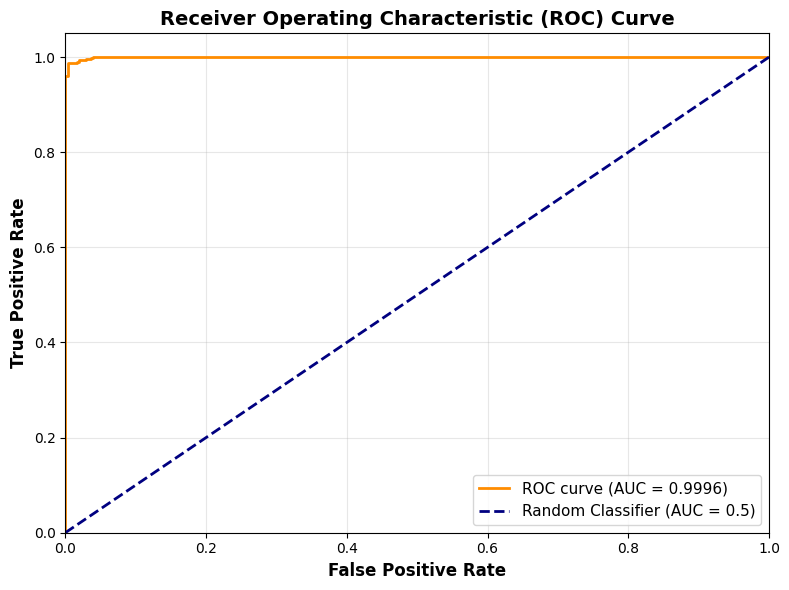

Precision-Recall curve saved to: pr_curve_test_checkpoint_epoch_0031.png


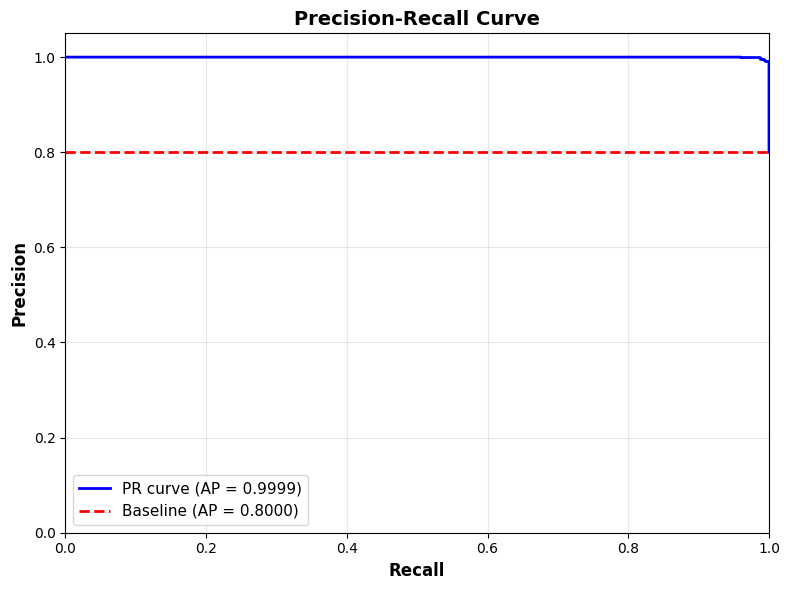

Confusion matrix saved to: confusion_matrix_test_checkpoint_epoch_0031.png


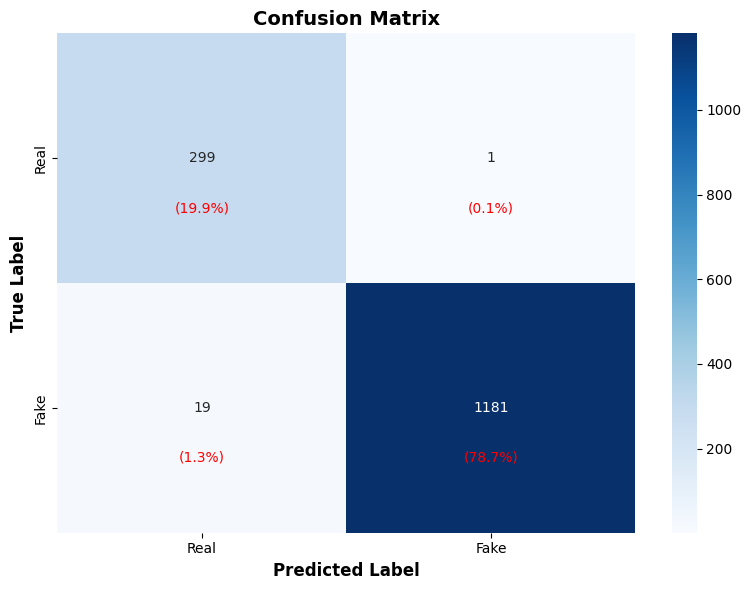

Normalized confusion matrix saved to: confusion_matrix_norm_test_checkpoint_epoch_0031.png


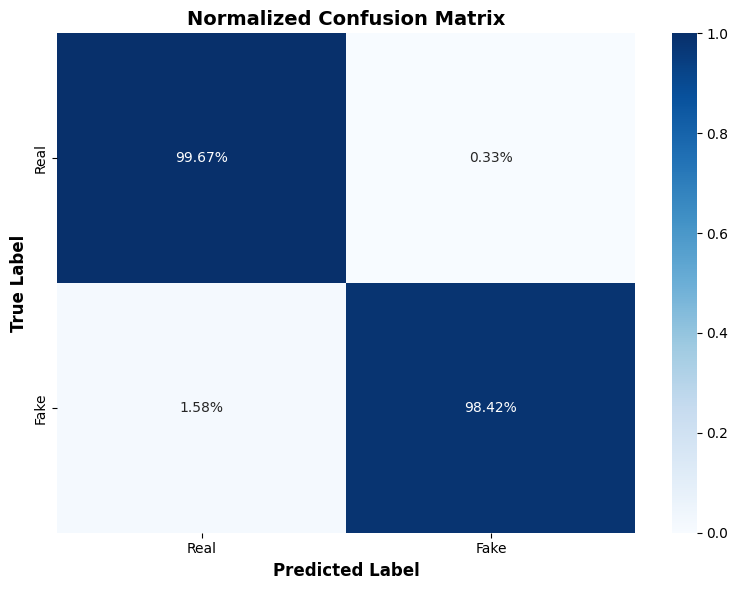

Combined metrics plot saved to: all_metrics_test_checkpoint_epoch_0031.png


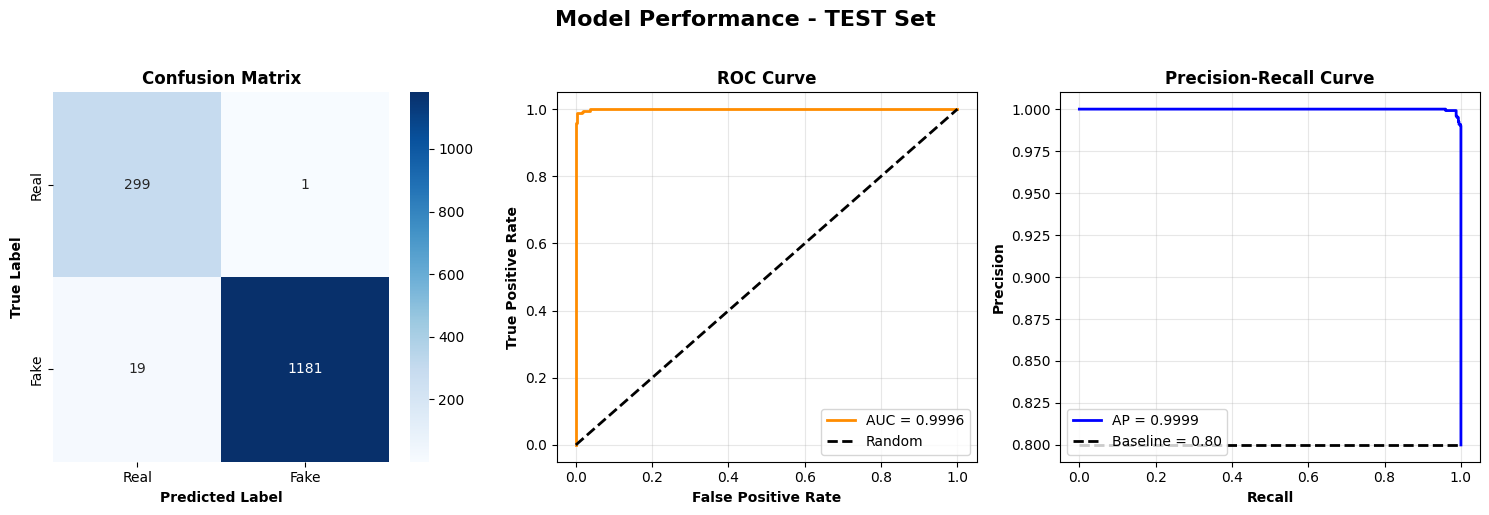

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataset import DFADDataset
# from DFAD_model_base import DFADModelRelu, DFADModelGELU
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                            recall_score, f1_score, confusion_matrix, 
                            roc_curve, auc)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_confusion_matrix(cm, save_path=None):
    """Plot confusion matrix with annotations"""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                cbar=True, ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    
    # Add percentage annotations
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = (cm[i, j] / total) * 100
            ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                   ha='center', va='center', fontsize=10, color='red')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()
    return fig

def plot_normalized_confusion_matrix(cm, save_path=None):
    """Plot normalized confusion matrix (percentages)"""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Normalize by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                cbar=True, ax=ax, vmin=0, vmax=1)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Normalized confusion matrix saved to: {save_path}")
    
    plt.show()
    return fig

def plot_roc_curve(labels, probabilities, save_path=None):
    """Plot ROC curve with AUC score"""
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, 
            label=f'ROC curve (AUC = {roc_auc:.4f})')
    
    # Plot diagonal line (random classifier)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
            label='Random Classifier (AUC = 0.5)')
    
    # Formatting
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', 
                fontsize=14, fontweight='bold')
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"ROC curve saved to: {save_path}")
    
    plt.show()
    return fig, roc_auc

def plot_precision_recall_curve(labels, probabilities, save_path=None):
    """Plot Precision-Recall curve"""
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(labels, probabilities)
    avg_precision = average_precision_score(labels, probabilities)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot PR curve
    ax.plot(recall, precision, color='blue', lw=2,
            label=f'PR curve (AP = {avg_precision:.4f})')
    
    # Plot baseline (proportion of positive class)
    baseline = labels.sum() / len(labels)
    ax.plot([0, 1], [baseline, baseline], color='red', lw=2, linestyle='--',
            label=f'Baseline (AP = {baseline:.4f})')
    
    # Formatting
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
    ax.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax.legend(loc="lower left", fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Precision-Recall curve saved to: {save_path}")
    
    plt.show()
    return fig, avg_precision

def plot_all_metrics(cm, labels, probabilities, split, checkpoint_name):
    """Create a comprehensive figure with all metrics"""
    fig = plt.figure(figsize=(15, 5))
    
    # Confusion Matrix
    ax1 = plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'],
                cbar=True, ax=ax1)
    ax1.set_xlabel('Predicted Label', fontweight='bold')
    ax1.set_ylabel('True Label', fontweight='bold')
    ax1.set_title('Confusion Matrix', fontweight='bold')
    
    # ROC Curve
    ax2 = plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(labels, probabilities)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    ax2.set_xlabel('False Positive Rate', fontweight='bold')
    ax2.set_ylabel('True Positive Rate', fontweight='bold')
    ax2.set_title('ROC Curve', fontweight='bold')
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    ax3 = plt.subplot(1, 3, 3)
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(labels, probabilities)
    avg_precision = average_precision_score(labels, probabilities)
    ax3.plot(recall, precision, color='blue', lw=2, label=f'AP = {avg_precision:.4f}')
    baseline = labels.sum() / len(labels)
    ax3.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'Baseline = {baseline:.2f}')
    ax3.set_xlabel('Recall', fontweight='bold')
    ax3.set_ylabel('Precision', fontweight='bold')
    ax3.set_title('Precision-Recall Curve', fontweight='bold')
    ax3.legend(loc="lower left")
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle(f'Model Performance - {split.upper()} Set', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    save_path = f'all_metrics_{split}_{checkpoint_name}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Combined metrics plot saved to: {save_path}")
    plt.show()
    
    return fig

def test_model(checkpoint_path, split='val', batch_size=2048, save_plots=True, mlp='base'):
    """Test a trained model checkpoint"""
    
    print(f"Loading model from: {checkpoint_path}")
    model = DFADModelRelu() if mlp=='base' else DFADModelGELU()
    model = nn.DataParallel(model, device_ids=[0]).cuda()
    
    # Load checkpoint
    state_dict = torch.load(checkpoint_path)
    model.load_state_dict(state_dict)
    model.eval()
    
    # Load dataset (val or test)
    print(f"Loading {split} dataset...")
    dataset = DFADDataset(split)
    loader = DataLoader(dataset, batch_size=batch_size, num_workers=8, shuffle=False)
    
    # Collect predictions
    all_labels = []
    all_predictions = []
    all_probabilities = []
    
    print("Running inference...")
    with torch.no_grad():
        for inputs, text_inputs, labels in loader:
            inputs = inputs.to(device)
            text_inputs = text_inputs.to(device)
            labels = labels.to(device)
            
            # Get model output
            output = model(inputs, text_inputs).squeeze()
            probabilities = torch.sigmoid(output)
            predicted = (probabilities > 0.5).float()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    roc_auc = roc_auc_score(all_labels, all_probabilities)
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Print results
    print("\n" + "="*60)
    print(f"TEST RESULTS - {split.upper()} SET")
    print("="*60)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC-ROC:   {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              Real  Fake")
    print(f"Actual Real   {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"       Fake   {cm[1,0]:4d}  {cm[1,1]:4d}")
    print("="*60)
    
    # Calculate per-class accuracy
    tn, fp, fn, tp = cm.ravel()
    real_accuracy = tn / (tn + fp) if (tn + fp) > 0 else 0
    fake_accuracy = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"\nPer-class Accuracy:")
    print(f"Real images: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
    print(f"Fake images: {fake_accuracy:.4f} ({fake_accuracy*100:.2f}%)")
    print("="*60)
    
    # Plot visualizations
    if save_plots:
        print("\nGenerating visualizations...")
        
        # Extract checkpoint name
        import os
        checkpoint_name = os.path.basename(checkpoint_path).replace('.pt', '')
        
        # Plot individual curves
        plot_roc_curve(all_labels, all_probabilities, 
                      save_path=f'roc_curve_{split}_{checkpoint_name}.png')
        
        plot_precision_recall_curve(all_labels, all_probabilities,
                                   save_path=f'pr_curve_{split}_{checkpoint_name}.png')
        
        plot_confusion_matrix(cm, 
                            save_path=f'confusion_matrix_{split}_{checkpoint_name}.png')
        
        plot_normalized_confusion_matrix(cm,
                                        save_path=f'confusion_matrix_norm_{split}_{checkpoint_name}.png')
        
        # Plot combined figure
        plot_all_metrics(cm, all_labels, all_probabilities, split, checkpoint_name)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'confusion_matrix': cm,
        'all_labels': all_labels,
        'all_probabilities': all_probabilities
    }

if __name__ == '__main__':
    # Test on validation set
    checkpoint_path = 'relu_af_checkpoints_auc_gamma_0.8_approx/checkpoint_epoch_0031.pt'

    # Test on test set
    print("\n\nTesting on TEST set:")
    test_results = test_model(checkpoint_path, split    ='test', save_plots=True, mlp='base')



Testing on TEST set:
Loading model from: gelu_af_checkpoints_auc_gamma_0.8_approx/checkpoint_epoch_0031.pt
Loading test dataset...
Running inference...

TEST RESULTS - TEST SET
Accuracy:  0.9800 (98.00%)
Precision: 0.9974
Recall:    0.9775
F1 Score:  0.9874
AUC-ROC:   0.9995

Confusion Matrix:
                Predicted
              Real  Fake
Actual Real    297     3
       Fake     27  1173

Per-class Accuracy:
Real images: 0.9900 (99.00%)
Fake images: 0.9775 (97.75%)

Generating visualizations...
ROC curve saved to: roc_curve_test_checkpoint_epoch_0031.png


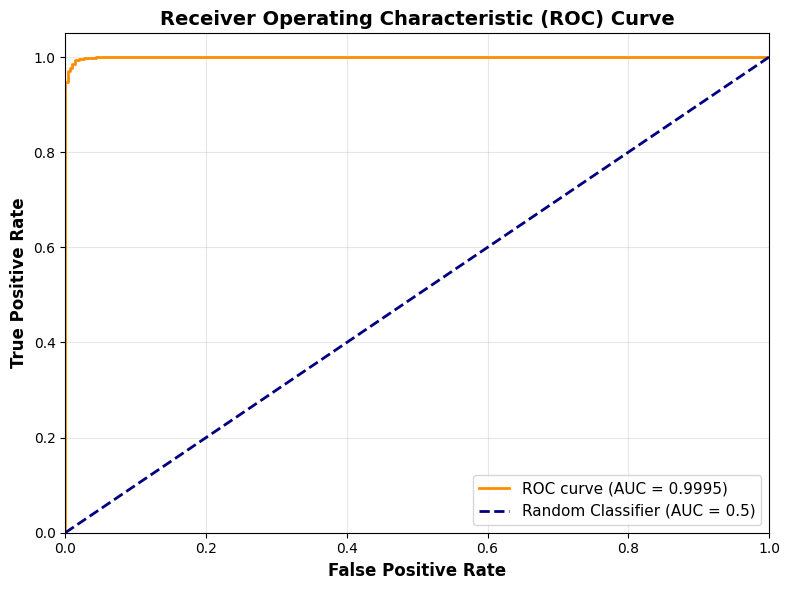

Precision-Recall curve saved to: pr_curve_test_checkpoint_epoch_0031.png


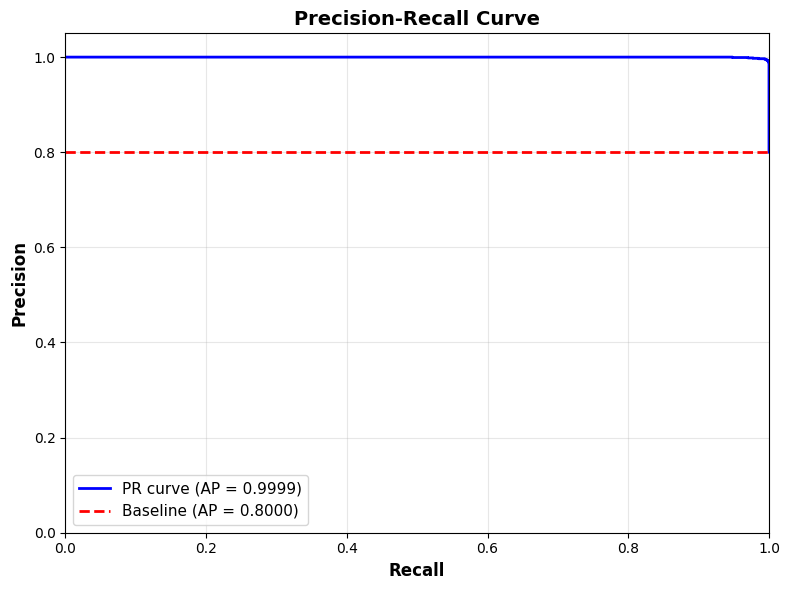

Confusion matrix saved to: confusion_matrix_test_checkpoint_epoch_0031.png


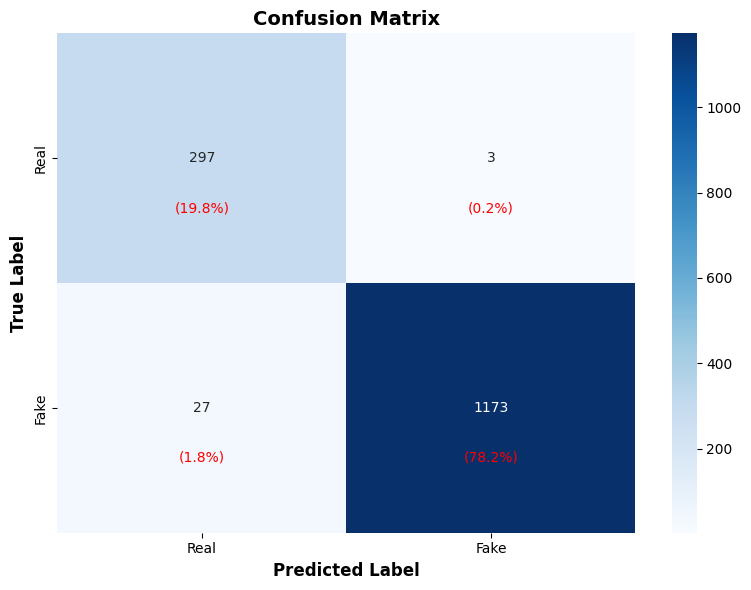

Normalized confusion matrix saved to: confusion_matrix_norm_test_checkpoint_epoch_0031.png


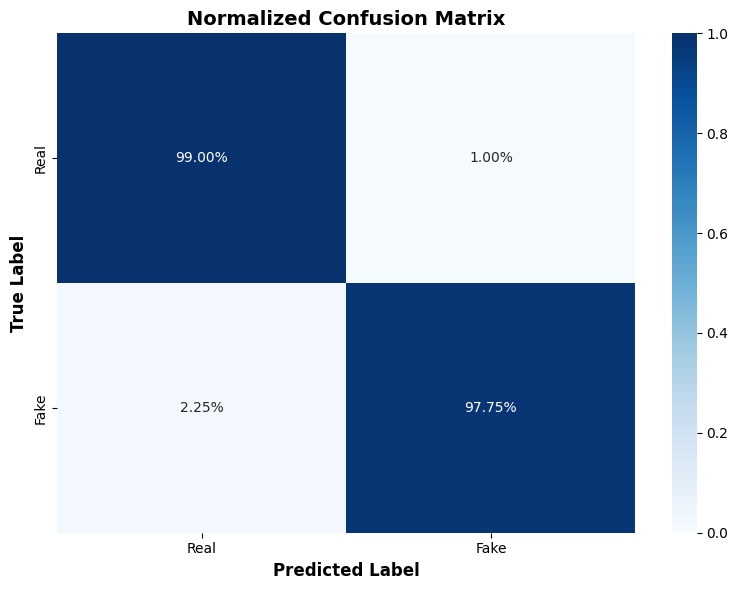

Combined metrics plot saved to: all_metrics_test_checkpoint_epoch_0031.png


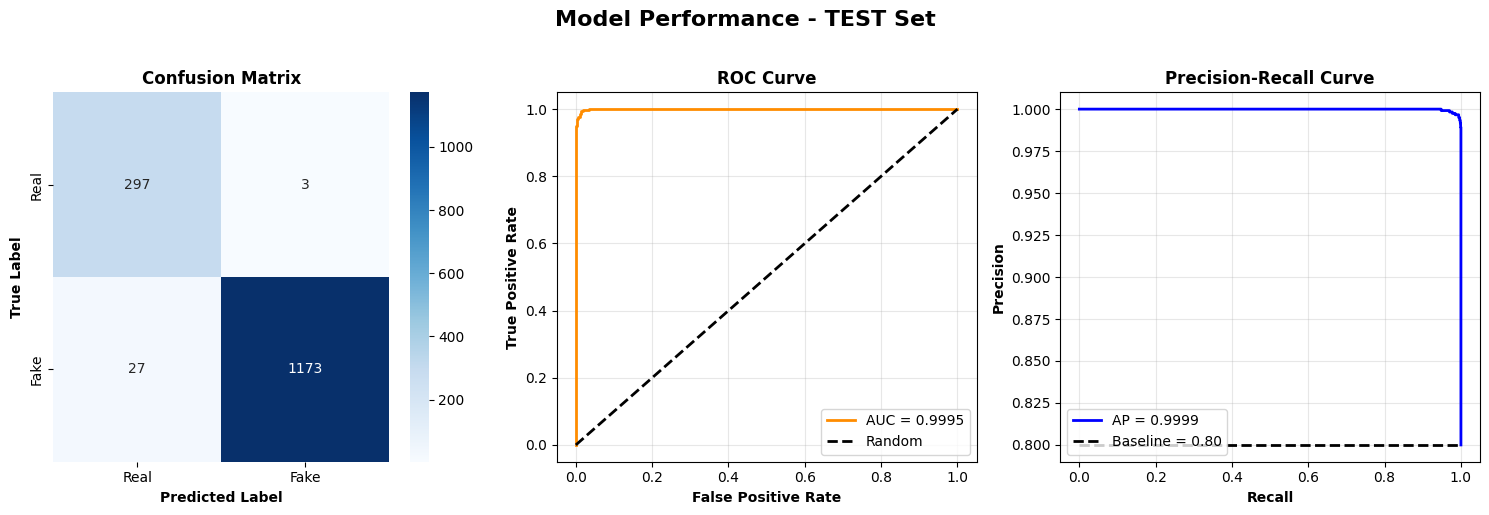

In [ ]:
if __name__ == '__main__':
    # Test on validation set
    checkpoint_path = 'gelu_af_checkpoints_auc_gamma_0.8_approx/checkpoint_epoch_0031.pt'

    # Test on test set
    print("\n\nTesting on TEST set:")
    test_results = test_model(checkpoint_path, split='test', save_plots=True, mlp='base')